In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import torch
import torch.nn as nn

In [2]:
class CNNBlock(nn.Module):
    def __init__ (self, in_channels, out_channels, stride=2):
        super().__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, 4, stride, bias=False, padding_mode="reflect"),
            nn.BatchNorm2d(out_channels),
            nn.LeakyReLU(0.2)
        )
        
    def forward(self, x):
        return self.conv(x)
    
class Discriminator(nn.Module):
    def __init__(self, in_channels=3, features=[64, 128, 256, 512]):
        super().__init__()
        # in_channels * 2 because we send in x, y and concat them along channels
        self.inital = nn.Sequential(
            nn.Conv2d(in_channels * 2, features[0], kernel_size=4, stride=2,padding=1, padding_mode="reflect"),
            nn.LeakyReLU(0.2)
        )
        
        layers = []
        in_channels = features[0]
        for feature in features[1:]:
            layers.append(
                CNNBlock(in_channels, feature, stride=1 if feature == features[-1] else 2)
            )
            in_channels = feature
            
        layers.append(nn.Conv2d(in_channels, 1, kernel_size=4, stride=1, padding=1, padding_mode='reflect'))
        
        self.model = nn.Sequential(*layers)
        
    def forward(self, x, y):
        # y is either fake or real
        x = torch.cat([x, y], dim=1)
        x = self.inital(x)
        return self.model(x)


x = torch.randn((1, 3, 256, 256))
y = torch.randn((1, 3, 256, 256))
model = Discriminator()
preds = model(x, y)
print(preds.shape)

torch.Size([1, 1, 26, 26])


In [3]:
#Kinda like UNet
class Block(nn.Module):
    def __init__(self, in_channels, out_channels, down=True, act='relu', use_dropout=False):
        super().__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, 4, 2, 1, bias=False, padding_mode='reflect')
            if down
            else nn.ConvTranspose2d(in_channels, out_channels, 4, 2, 1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU() if act == 'relu' else nn.LeakyReLU(0.2)
        )
        self.use_dropout = use_dropout
        self.dropout = nn.Dropout(0.5)
        
    def forward(self, x):
        x = self.conv(x)
        return self.dropout(x) if self.use_dropout else x
    
class Generator(nn.Module):
    def __init__(self, in_channels=3, features=64):
        super().__init__()
        self.initial_down = nn.Sequential(
            nn.Conv2d(in_channels, features, 4, 2, 1, padding_mode='reflect'),
            nn.LeakyReLU(0.2)
        )
        
        self.down1 = Block(features, features*2, down=True, act='leaky', use_dropout=False) # 64
        self.down2 = Block(features*2, features*4, down=True, act='leaky', use_dropout=False) # 32
        self.down3 = Block(features*4, features*8, down=True, act='leaky', use_dropout=False) # 16
        self.down4 = Block(features*8, features*8, down=True, act='leaky', use_dropout=False) # 8
        self.down5 = Block(features*8, features*8, down=True, act='leaky', use_dropout=False) # 4
        self.down6 = Block(features*8, features*8, down=True, act='leaky', use_dropout=False) # 2

        self.bottleneck= nn.Sequential(
            nn.Conv2d(features*8, features*8, 4, 2, 1, padding_mode='reflect'), nn.ReLU() # 1x1
        )
        
        self.up1 = Block(features*8, features*8, down=False, act='relu', use_dropout=True)
        self.up2 = Block(features*8*2, features*8, down=False, act='relu', use_dropout=True)
        self.up3 = Block(features*8*2, features*8, down=False, act='relu', use_dropout=True)
        self.up4 = Block(features*8*2, features*8, down=False, act='relu', use_dropout=False)
        self.up5 = Block(features*8*2, features*4, down=False, act='relu', use_dropout=False)
        self.up6 = Block(features*4*2, features*2, down=False, act='relu', use_dropout=False)
        self.up7 = Block(features*2*2, features, down=False, act='relu', use_dropout=False)
        
        self.final_up = nn.Sequential(
            nn.ConvTranspose2d(features*2, in_channels, kernel_size=4, stride=2, padding=1),
            nn.Tanh()
        )
        
    def forward(self, x):
        d1 = self.initial_down(x)
        d2 = self.down1(d1)
        d3 = self.down2(d2)
        d4 = self.down3(d3)
        d5 = self.down4(d4)
        d6 = self.down5(d5)
        d7 = self.down6(d6)
        bottleneck = self.bottleneck(d7)
            
        up1 = self.up1(bottleneck)
        up2 = self.up2(torch.cat([up1, d7], 1))
        up3 = self.up3(torch.cat([up2, d6], 1))
        up4 = self.up4(torch.cat([up3, d5], 1))
        up5 = self.up5(torch.cat([up4, d4], 1))
        up6 = self.up6(torch.cat([up5, d3], 1))
        up7 = self.up7(torch.cat([up6, d2], 1))
        return self.final_up(torch.cat([up7, d1], 1))
        
x = torch.randn((1, 3, 256, 256))
model = Generator()
preds = model(x)
print(preds.shape)

torch.Size([1, 3, 256, 256])


In [10]:
import torch
import albumentations as A
from albumentations.pytorch import ToTensorV2

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
TRAIN_DIR = "data/train"
VAL_DIR = "data/val"
LEARNING_RATE = 2e-4
BATCH_SIZE = 16
NUM_WORKERS = 2
IMAGE_SIZE = 256
CHANNELS_IMG = 3
L1_LAMBDA = 100
LAMBDA_GP = 10
NUM_EPOCHS = 500
LOAD_MODEL = True
SAVE_MODEL = True
CHECKPOINT_DISC = "disc.pth.tar"
CHECKPOINT_GEN = "gen.pth.tar"

both_transform = A.Compose(
    [A.Resize(width=256, height=256),], additional_targets={"image0": "image"},
)

transform_only_input = A.Compose(
    [
        A.HorizontalFlip(p=0.5),
        A.ColorJitter(p=0.2),
        A.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5], max_pixel_value=255.0,),
        ToTensorV2(),
    ]
)

transform_only_mask = A.Compose(
    [
        A.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5], max_pixel_value=255.0,),
        ToTensorV2(),
    ]
)

In [5]:
from PIL import Image
import os
from torch.utils.data import Dataset

class AnimeDataset(Dataset):
    def __init__(self, root_dir):
        self.root_dir = root_dir
        self.list_file = os.listdir(self.root_dir)

        
    def __len__(self):
        return len(self.list_file)
    

    def __getitem__(self, index):
        img_file = self.list_file[index]
        img_path = os.path.join(self.root_dir, img_file)
        img = np.array(Image.open(img_path))
        input_img = img[:, :512, :]
        target_img = img[:, 512:, :]
        
        augmentations = both_transform(image=input_img, image0=target_img)
        input_img, target_img = augmentations['image'], augmentations['image0']
        
        input_img = transform_only_input(image=input_img)['image']
        target_img = transform_only_mask(image=target_img)['image']
        
        return input_img, target_img

In [6]:
from torch.utils.data import DataLoader
te_dataset = AnimeDataset(root_dir='/kaggle/input/anime-sketch-colorization-pair/data/train/')
te_loader = DataLoader(te_dataset, batch_size=1, shuffle=True, num_workers=1)

batch= iter(te_loader)
images, labels = next(batch)

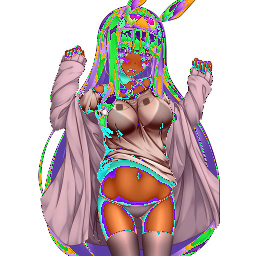

In [7]:
import torchvision.transforms as T
images[0].shape
transform = T.ToPILImage()
transform(images[0])

In [11]:
import torch
from torchvision.utils import save_image

def save_some_examples(gen, val_loader, epoch, folder):
    x, y = next(iter(val_loader))
    x, y = x.to(DEVICE), y.to(DEVICE)
    gen.eval()
    with torch.no_grad():
        y_fake = gen(x)
        y_fake = y_fake * 0.5 + 0.5  # remove normalization#
        save_image(y_fake, folder + f"/y_gen_{epoch}.png")
        save_image(x * 0.5 + 0.5, folder + f"/input_{epoch}.png")
        if epoch == 1:
            save_image(y * 0.5 + 0.5, folder + f"/label_{epoch}.png")
    gen.train()


def save_checkpoint(model, optimizer, filename="my_checkpoint.pth.tar"):
    checkpoint = {
        "state_dict": model.state_dict(),
        "optimizer": optimizer.state_dict(),
    }
    torch.save(checkpoint, filename)


def load_checkpoint(checkpoint_file, model, optimizer, lr):
    checkpoint = torch.load("/kaggle/input/models/" + checkpoint_file, map_location=DEVICE)
    model.load_state_dict(checkpoint["state_dict"])
    optimizer.load_state_dict(checkpoint["optimizer"])
    for param_group in optimizer.param_groups:
        param_group["lr"] = lr


In [12]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from tqdm import tqdm
from torchvision.utils import save_image
print(SAVE_MODEL)
torch.backends.cudnn.benchmark = True

def train_fn(disc, gen, train_loader, opt_disc, opt_gen, L1_LOSS, BCE, g_scaler, d_scaler):
    loop = tqdm(train_loader, leave=True)
    
    for idx, (x, y) in enumerate(loop):
        x, y = x.to(DEVICE), y.to(DEVICE)
        
        #Train Discriminator
        with torch.cuda.amp.autocast():
            y_fake = gen(x)
            D_real = disc(x, y)
            D_fake = disc(x, y_fake.detach())
            
            D_real_loss = BCE(D_real, torch.ones_like(D_real))
            D_fake_loss = BCE(D_fake, torch.zeros_like(D_fake))

            D_loss = (D_real_loss + D_fake_loss) / 2
            
        opt_disc.zero_grad()
        d_scaler.scale(D_loss).backward()
        d_scaler.step(opt_disc)
        d_scaler.update()
        
        #Train Generator
        with torch.cuda.amp.autocast():
            D_fake = disc(x, y_fake)
            
            G_fake_loss = BCE(D_fake, torch.ones_like(D_fake))
            L1 = L1_LOSS(y_fake, y) * L1_LAMBDA
            G_LOSS = G_fake_loss + L1
            
                       
        opt_gen.zero_grad()
        g_scaler.scale(G_LOSS).backward()
        g_scaler.step(opt_gen)
        g_scaler.update() 
        
def main():
    disc = Discriminator(in_channels=3).to(DEVICE)
    gen = Generator(in_channels=3).to(DEVICE)
    opt_disc=optim.Adam(disc.parameters(), lr=LEARNING_RATE, betas=(0.5, 0.999))
    opt_gen=optim.Adam(gen.parameters(), lr=LEARNING_RATE, betas=(0.5, 0.999))
    
    BCE = nn.BCEWithLogitsLoss()
    L1_LOSS = nn.L1Loss()
    
    if LOAD_MODEL:
        load_checkpoint(CHECKPOINT_GEN, gen, opt_gen, LEARNING_RATE)
        load_checkpoint(CHECKPOINT_DISC, disc, opt_disc, LEARNING_RATE)
        
    train_dataset = AnimeDataset(root_dir='/kaggle/input/anime-sketch-colorization-pair/data/train/')
    train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=NUM_WORKERS)
    
    g_scaler = torch.cuda.amp.GradScaler()
    d_scaler = torch.cuda.amp.GradScaler()
    
    val_dataset = AnimeDataset(root_dir='/kaggle/input/anime-sketch-colorization-pair/data/val/')
    val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=NUM_WORKERS)
    
    for epoch in range(NUM_EPOCHS):
        train_fn(disc, gen, train_loader, opt_disc, opt_gen, L1_LOSS, BCE, g_scaler, d_scaler)
        
        if(SAVE_MODEL and epoch % 5 == 0):
            save_checkpoint(gen, opt_gen, filename=CHECKPOINT_GEN)
            save_checkpoint(disc, opt_disc, filename=CHECKPOINT_DISC)
            
        save_some_examples(gen, val_loader, epoch, folder='.')
        
main()

True
=> Loading checkpoint
=> Loading checkpoint


100%|██████████| 889/889 [04:38<00:00,  3.19it/s]


=> Saving checkpoint
=> Saving checkpoint


100%|██████████| 889/889 [04:38<00:00,  3.20it/s]


=> Saving checkpoint
=> Saving checkpoint


100%|██████████| 889/889 [04:39<00:00,  3.18it/s]


=> Saving checkpoint
=> Saving checkpoint


100%|██████████| 889/889 [04:38<00:00,  3.20it/s]


=> Saving checkpoint
=> Saving checkpoint


100%|██████████| 889/889 [04:38<00:00,  3.20it/s]


=> Saving checkpoint
=> Saving checkpoint


100%|██████████| 889/889 [04:37<00:00,  3.20it/s]


=> Saving checkpoint
=> Saving checkpoint


  6%|▌         | 54/889 [00:17<04:36,  3.02it/s]
